In [2]:
from tqdm import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [3]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [4]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)
]

100%|██████████| 2647/2647 [00:00<00:00, 23548.56it/s]


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Model's maximum sequence length: 512


100%|██████████| 31085/31085 [00:18<00:00, 1704.86it/s]


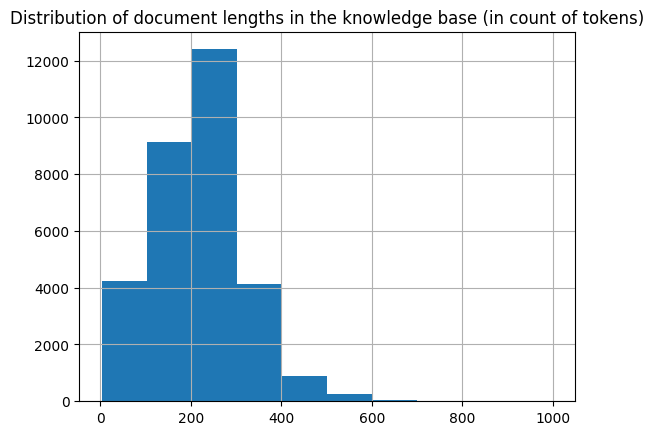

In [6]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter
print(f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distribution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

100%|██████████| 17995/17995 [00:14<00:00, 1264.35it/s]


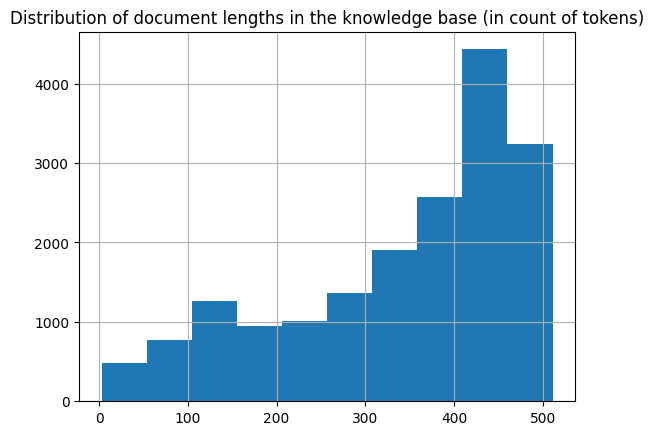

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [15]:
import torch
import platform
def get_device(): 

    os_name = platform.system()

    # on mac try to use mps
    if os_name == 'Darwin' :
        if torch.backends.mps.is_available():
            print("MPS available...")
            return torch.device("mps")
        else:
            if torch.backends.mps.is_built():
                print("MPS not available because the current MacOS version is not 12.3+ "
                      "and/or you do not have an MPS-enabled device on this machine.")
            else: 
                  print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
            print("Using cpu device for mac os...")
            return torch.device("cpu")

    # on windows try to use DirectML
    if os_name == 'Windows' :
        import torch_directml
        try: 
            dml = torch_directml.device()
            print("DirectML available...")
            return dml
        except Exception as e:
            print(f"DirectML is not available: {e}")
            print("Using cpu device for windows os...")
            return torch.device("cpu")

    
    print("Using cpu device...")
    return torch.device("cpu")
get_device()

MPS available...


device(type='mps')

In [9]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

# embedding_model = HuggingFaceEmbeddings(
#     model_name=EMBEDDING_MODEL_NAME,
#     multi_process=True,
#     model_kwargs={"device": "mps"},
#     encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
# )


# KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
#     docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
# )

In [14]:
from tqdm.auto import tqdm
import torch

# Increase batch size for better GPU utilization
BATCH_SIZE = 64  # You can adjust this based on your GPU memory

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},
)

print("Step 1: Creating embeddings")
texts = [doc.page_content for doc in docs_processed]

# Process in batches
embeddings = []
for i in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[i:i + BATCH_SIZE]
    batch_embeddings = embedding_model.embed_documents(batch_texts)
    embeddings.extend(batch_embeddings)

print("Step 2: Creating FAISS index")
with tqdm(total=1) as pbar:
    KNOWLEDGE_VECTOR_DATABASE = FAISS.from_embeddings(
        text_embeddings=list(zip(texts, embeddings)),
        embedding=embedding_model,
        distance_strategy=DistanceStrategy.COSINE
    )
    pbar.update(1)

Step 1: Creating embeddings


  0%|          | 0/282 [00:00<?, ?it/s]

Step 2: Creating FAISS index


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
import time
import psutil
import torch
from tqdm.auto import tqdm

def benchmark_batch_size(texts, batch_sizes=[8, 16, 32, 64, 128, 256]):
    results = []
    
    for batch_size in batch_sizes:
        # Clear GPU cache before each test
        if torch.has_mps:
            torch.mps.empty_cache()
            
        embedding_model = HuggingFaceEmbeddings(
            model_name=EMBEDDING_MODEL_NAME,
            model_kwargs={"device": "mps"},
            encode_kwargs={"normalize_embeddings": True, "batch_size": batch_size}
        )
        
        # Measure initial memory
        initial_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        # Time the embedding process
        start_time = time.time()
        embeddings = []
        
        try:
            for i in tqdm(range(0, len(texts), batch_size), desc=f"Batch size {batch_size}"):
                batch_texts = texts[i:i + batch_size]
                batch_embeddings = embedding_model.embed_documents(batch_texts)
                embeddings.extend(batch_embeddings)
                
            end_time = time.time()
            duration = end_time - start_time
            
            # Measure peak memory
            peak_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
            memory_used = peak_memory - initial_memory
            
            results.append({
                'batch_size': batch_size,
                'duration': duration,
                'memory_used': memory_used,
                'success': True
            })
            
        except RuntimeError as e:  # Catch out of memory errors
            results.append({
                'batch_size': batch_size,
                'duration': None,
                'memory_used': None,
                'success': False,
                'error': str(e)
            })
            
        print(f"\nBatch size {batch_size}:")
        print(f"Time taken: {duration:.2f} seconds")
        print(f"Memory used: {memory_used:.2f} MB")
        
    return results

# Run benchmark
texts = [doc.page_content for doc in docs_processed]
results = benchmark_batch_size(texts)

# Print results in a table
print("\nBenchmark Results:")
print("-" * 80)
print(f"{'Batch Size':^10} | {'Duration (s)':^15} | {'Memory (MB)':^15} | {'Success':^10}")
print("-" * 80)
for r in results:
    if r['success']:
        print(f"{r['batch_size']:^10} | {r['duration']:^15.2f} | {r['memory_used']:^15.2f} | {'✓':^10}")
    else:
        print(f"{r['batch_size']:^10} | {'FAILED':^15} | {'FAILED':^15} | {'✗':^10}")

/var/folders/sx/8fyf1ly16gg424mjwybtpf8h0000gn/T/ipykernel_15918/1686867362.py:11: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if torch.has_mps:
/var/folders/sx/8fyf1ly16gg424mjwybtpf8h0000gn/T/ipykernel_15918/1686867362.py:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


Batch size 8:   0%|          | 0/2250 [00:00<?, ?it/s]

KeyboardInterrupt: 

Testing with 1000 samples, 5 batches per size


/var/folders/sx/8fyf1ly16gg424mjwybtpf8h0000gn/T/ipykernel_15918/2393986359.py:21: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if torch.has_mps:



Batch size 8:
Avg time per batch: 0.53 ± 0.05 seconds
Estimated full time: 1189.25 seconds

Batch size 16:
Avg time per batch: 1.03 ± 0.07 seconds
Estimated full time: 1161.59 seconds

Batch size 32:
Avg time per batch: 2.07 ± 0.21 seconds
Estimated full time: 1166.53 seconds

Batch size 64:
Avg time per batch: 3.89 ± 0.05 seconds
Estimated full time: 1092.85 seconds

Batch size 128:
Avg time per batch: 32.21 ± 28.86 seconds
Estimated full time: 4527.65 seconds


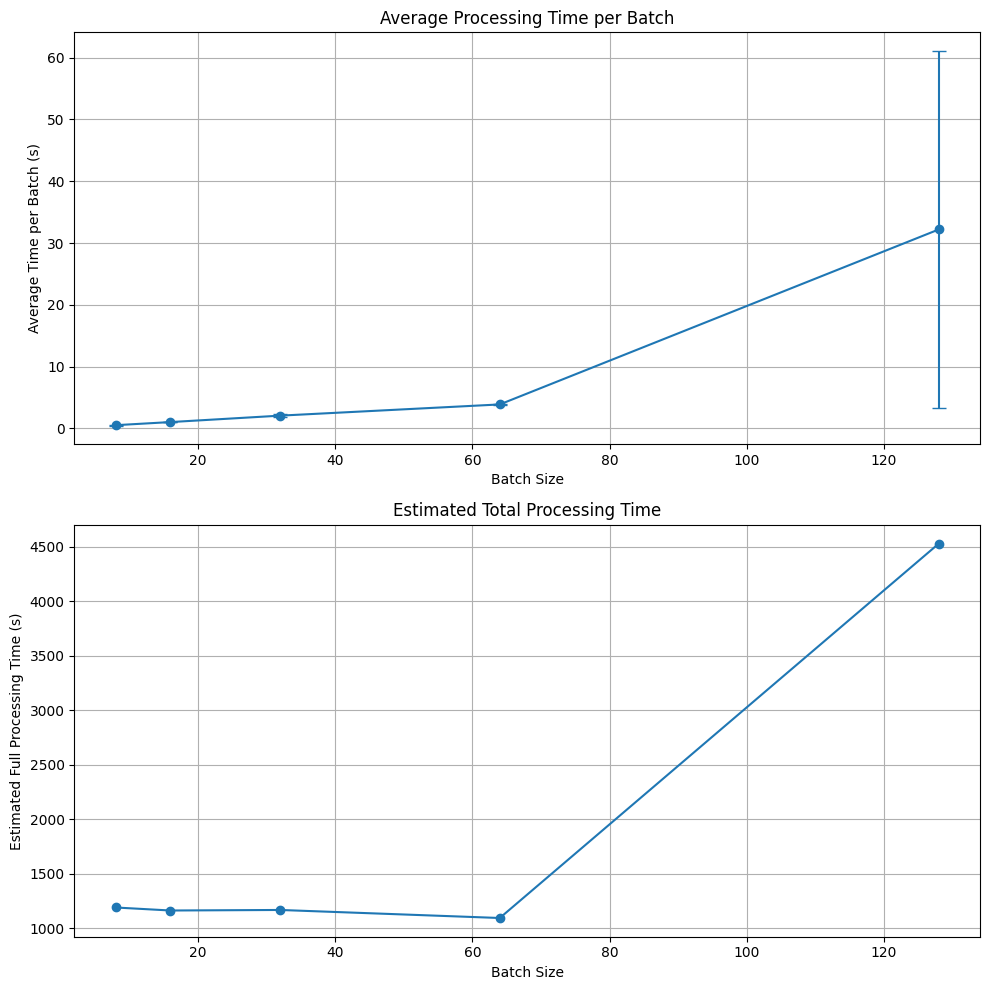


Benchmark Results Summary:
----------------------------------------------------------------------------------------------------
 Batch Size  |    Avg Time/Batch    |   Std Dev    |    Est. Full Time    |   Status  
----------------------------------------------------------------------------------------------------
     8       |        0.529         |    0.050     |       1189.25        |     ✓     
     16      |        1.033         |    0.065     |       1161.59        |     ✓     
     32      |        2.074         |    0.206     |       1166.53        |     ✓     
     64      |        3.887         |    0.053     |       1092.85        |     ✓     
    128      |        32.206        |    28.865    |       4527.65        |     ✓     


In [13]:
import time
import psutil
import torch
from tqdm.auto import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

def quick_benchmark_batch_size(texts, num_samples=1000, batch_sizes=[8, 16, 32, 64, 128], num_batches=5):
    # Take a random sample of texts for faster testing
    if len(texts) > num_samples:
        sample_texts = random.sample(texts, num_samples)
    else:
        sample_texts = texts

    results = []
    print(f"Testing with {len(sample_texts)} samples, {num_batches} batches per size")
    
    for batch_size in batch_sizes:
        # Clear GPU cache
        if torch.has_mps:
            torch.mps.empty_cache()
            
        embedding_model = HuggingFaceEmbeddings(
            model_name=EMBEDDING_MODEL_NAME,
            model_kwargs={"device": "mps"},
            encode_kwargs={"normalize_embeddings": True, "batch_size": batch_size}
        )
        
        try:
            # Warmup run
            warmup_batch = sample_texts[:batch_size]
            _ = embedding_model.embed_documents(warmup_batch)
            
            # Time multiple batches
            batch_times = []
            for i in range(num_batches):
                start_idx = (i * batch_size) % (len(sample_texts) - batch_size)
                test_batch = sample_texts[start_idx:start_idx + batch_size]
                
                start_time = time.time()
                _ = embedding_model.embed_documents(test_batch)
                duration = time.time() - start_time
                batch_times.append(duration)
            
            avg_duration = np.mean(batch_times)
            std_duration = np.std(batch_times)
            
            # Extrapolate to full dataset
            total_batches_needed = len(texts) / batch_size
            estimated_full_duration = avg_duration * total_batches_needed
            
            results.append({
                'batch_size': batch_size,
                'avg_duration_per_batch': avg_duration,
                'std_duration': std_duration,
                'batch_times': batch_times,
                'estimated_full_duration': estimated_full_duration,
                'success': True
            })
            
            print(f"\nBatch size {batch_size}:")
            print(f"Avg time per batch: {avg_duration:.2f} ± {std_duration:.2f} seconds")
            print(f"Estimated full time: {estimated_full_duration:.2f} seconds")
            
        except RuntimeError as e:
            results.append({
                'batch_size': batch_size,
                'avg_duration_per_batch': None,
                'std_duration': None,
                'batch_times': None,
                'estimated_full_duration': None,
                'success': False,
                'error': str(e)
            })
            print(f"\nBatch size {batch_size}: Failed with error")
    
    return results

def plot_benchmark_results(results):
    # Filter successful results
    successful_results = [r for r in results if r['success']]
    
    # Prepare data for plotting
    batch_sizes = [r['batch_size'] for r in successful_results]
    avg_times = [r['avg_duration_per_batch'] for r in successful_results]
    std_times = [r['std_duration'] for r in successful_results]
    est_full_times = [r['estimated_full_duration'] for r in successful_results]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot average batch times with error bars
    ax1.errorbar(batch_sizes, avg_times, yerr=std_times, fmt='o-', capsize=5)
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Average Time per Batch (s)')
    ax1.set_title('Average Processing Time per Batch')
    ax1.grid(True)
    
    # Plot estimated full processing times
    ax2.plot(batch_sizes, est_full_times, 'o-')
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Estimated Full Processing Time (s)')
    ax2.set_title('Estimated Total Processing Time')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print tabulated results
    print("\nBenchmark Results Summary:")
    print("-" * 100)
    print(f"{'Batch Size':^12} | {'Avg Time/Batch':^20} | {'Std Dev':^12} | {'Est. Full Time':^20} | {'Status':^10}")
    print("-" * 100)
    for r in results:
        if r['success']:
            print(f"{r['batch_size']:^12} | {r['avg_duration_per_batch']:^20.3f} | {r['std_duration']:^12.3f} | "
                  f"{r['estimated_full_duration']:^20.2f} | {'✓':^10}")
        else:
            print(f"{r['batch_size']:^12} | {'FAILED':^20} | {'FAILED':^12} | {'FAILED':^20} | {'✗':^10}")

# Example usage:
texts = [doc.page_content for doc in docs_processed]
results = quick_benchmark_batch_size(texts, num_samples=1000, batch_sizes=[8, 16, 32, 64, 128], num_batches=5)
plot_benchmark_results(results)

In [16]:
# Embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)
query_vector

[-0.06398776918649673,
 -0.00822095200419426,
 0.02044011652469635,
 -0.029721511527895927,
 -0.0671917274594307,
 -0.014577669091522694,
 0.011239297688007355,
 0.012274953536689281,
 -0.018703842535614967,
 0.03649056330323219,
 -0.045581478625535965,
 -0.10459045320749283,
 0.0354350209236145,
 -0.019231082871556282,
 -0.005539746023714542,
 0.018870867788791656,
 -0.009171197190880775,
 0.08943178504705429,
 -0.07621366530656815,
 -0.006646307650953531,
 0.07601319998502731,
 -0.0168040432035923,
 -0.049049798399209976,
 -0.05414339527487755,
 0.029905375093221664,
 0.0322149321436882,
 -0.012841430492699146,
 0.005498250015079975,
 0.0003802730643656105,
 -0.18671771883964539,
 -0.011808563955128193,
 -0.06362111121416092,
 0.039563022553920746,
 -0.005281325429677963,
 -0.010638539679348469,
 -0.04624650999903679,
 -0.007559359073638916,
 0.05203242599964142,
 -0.06777919083833694,
 0.047472406178712845,
 0.04452493414282799,
 0.018042219802737236,
 -0.03349024057388306,
 -0.0496

In [19]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [20]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

In [28]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query='what is encoder/decoder architecture?', k=5)
print("\n==================================Top document==================================")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
n this video, we'll study the decoder architecture. An example of a popular decoder-only architecture is GPT-2. In order to understand how decoders work, we recommend taking a look at the video regarding encoders: they're extremely similar to decoders. One can use a decoder for most of the same tasks as an encoder, albeit with, generally, a little loss of performance. Let's take the same approach we have taken with the encoder to try and understand the architectural differences between an encoder and a decoder. We'll use a small example, using three words. We pass
==================================Metadata==================================
{}


In [ ]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`